# **Flight Delay Prediction**

Autor: João Vitor Ferreira França

Os dados em questão tratam de voos dos Estados Unidos realizados em Janeiro de 2019 e 2020, coletados a partir da *Bureau of Transportation Statistics*. O principal o objetivo desta modelagem é predizer se um voo sofrerá ou não atraso (*delay*).

Os principais pontos do trabalho são os seguintes:

*   Exploração uni e multivariada
*   Entendimento do comportamento estatístico das variáveis
*   Busca por insights para auxilar a predição dos atrasos  
*   Pré processamento e engenharia de características
*   Criação do modelo
*   Avaliação das características
*   Avaliação dos resultados

## **Preparando o ambiente**

Instalando as bibliotecas que serão utilizadas e conectando com o drive para adquirir a base

In [1]:
"""
Importando bibliotecas que serão utilizadas na modelagem
do problema
"""
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import category_encoders as ce
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

shap.initjs()

sns.set();

%matplotlib inline

## **Análise dos dados**

Análise inicial dos dados para entendimento do problema e das variáveis

In [2]:
"""
Recuperando as bases de dados
"""
flights_2019 = pd.read_csv('../data/Jan_2019_ontime.csv')
flights_2020 = pd.read_csv('../data/Jan_2020_ontime.csv')

In [3]:
"""
Concatenando as duas bases
"""
data = pd.concat([flights_2019, flights_2020])
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN


In [ ]:
"""
Excluindo coluna sem informações
"""
data.drop(columns=['Unnamed: 21'], inplace=True)

In [ ]:
"""
Buscando informações iniciais sobre os dados
"""
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191331 entries, 0 to 607345
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   DAY_OF_MONTH           1191331 non-null  int64  
 1   DAY_OF_WEEK            1191331 non-null  int64  
 2   OP_UNIQUE_CARRIER      1191331 non-null  object 
 3   OP_CARRIER_AIRLINE_ID  1191331 non-null  int64  
 4   OP_CARRIER             1191331 non-null  object 
 5   TAIL_NUM               1188090 non-null  object 
 6   OP_CARRIER_FL_NUM      1191331 non-null  int64  
 7   ORIGIN_AIRPORT_ID      1191331 non-null  int64  
 8   ORIGIN_AIRPORT_SEQ_ID  1191331 non-null  int64  
 9   ORIGIN                 1191331 non-null  object 
 10  DEST_AIRPORT_ID        1191331 non-null  int64  
 11  DEST_AIRPORT_SEQ_ID    1191331 non-null  int64  
 12  DEST                   1191331 non-null  object 
 13  DEP_TIME               1168315 non-null  float64
 14  DEP_DEL15          

In [ ]:
"""
Verificando valores nulos de forma ordenada
"""
data.isna().mean().sort_values(ascending=False)

Unnamed: 21              1.000000
ARR_DEL15                0.021908
ARR_TIME                 0.020260
DEP_DEL15                0.019351
DEP_TIME                 0.019320
TAIL_NUM                 0.002720
ORIGIN_AIRPORT_SEQ_ID    0.000000
DAY_OF_WEEK              0.000000
OP_UNIQUE_CARRIER        0.000000
OP_CARRIER_AIRLINE_ID    0.000000
OP_CARRIER               0.000000
OP_CARRIER_FL_NUM        0.000000
ORIGIN_AIRPORT_ID        0.000000
DEST_AIRPORT_ID          0.000000
ORIGIN                   0.000000
DISTANCE                 0.000000
DEST_AIRPORT_SEQ_ID      0.000000
DEST                     0.000000
DEP_TIME_BLK             0.000000
CANCELLED                0.000000
DIVERTED                 0.000000
DAY_OF_MONTH             0.000000
dtype: float64

**Comentários:** Percebe-se que apenas uma das colunas possui um número considerável de valores nulos, por isso ela será excluída

In [ ]:
"""
Buscando colunas com o desvio padrão muito baixo (desbalanceadas)
"""
data.std()[data.std() < 0.2]

CANCELLED    0.139502
DIVERTED     0.045265
dtype: float64

**Comentários:** Percebe-se que estas duas colunas possuem um desbalanceamento muito alto, portanto não parecem ser variávieis que irão ajudar na modelagem

In [ ]:
"""
Dropando colunas com variância muito baixa
"""
data.drop(columns=data.std()[data.std() < 0.2].index.values, inplace=True)

In [ ]:
"""
Excluíndo duas das três colunas que identificam 
a linha aérea, já que mostram a mesma informação
"""
data.drop(columns=['OP_CARRIER_AIRLINE_ID', 'OP_UNIQUE_CARRIER'], inplace=True)

In [ ]:
"""
Excluíndo duas das três colunas que identificam 
a o aeroporto de origem
"""
data.drop(columns=['ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID'], inplace=True)

In [ ]:
"""
Excluíndo duas das três colunas que identificam 
a o aeroporto de destino
"""
data.drop(columns=['DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID'], inplace=True)

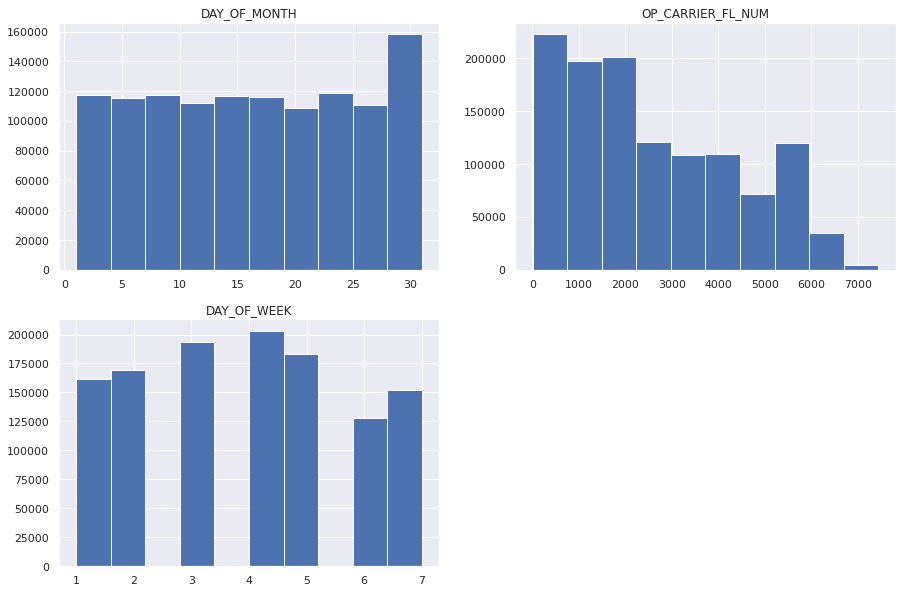

In [ ]:
"""
Plotando o histograma das colunas com inteiros, para um entendimento
preliminar sobre a distribuição dos dados
"""
numeric_columns = data.select_dtypes(include='int').columns

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10));
for i, column in enumerate(numeric_columns):
    index_row = i % 2
    index_column = i // 2
    axes[index_row, index_column].hist(data[column])
    axes[index_row, index_column].set_title(column)
fig.delaxes(axes[1,1])

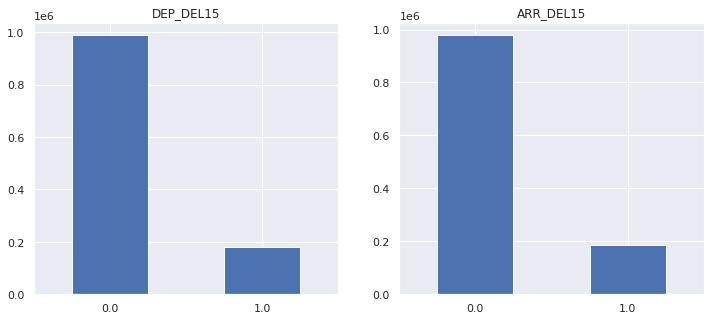

In [ ]:
"""
Plotando as colunas referentes a delay: delay de partida e de chegada
"""
columns = ['DEP_DEL15', 'ARR_DEL15']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5));
for i, column in enumerate(columns):
    index_column = i // 1
    fig.add_subplot(data[column].value_counts().plot.bar(ax=axes[index_column],
                                                         title=column, rot=0))

**Comentários:** Dois principais pontos podem ser observados: existe um desbalanceamento perceptível na variável alvo e o voo ter partido da origem com atraso é um forte indicativo de que irá se atrasar na chegada. Portanto, são altamente correlacionadas.

In [ ]:
def taxa_atraso(data, column):
    """
    Função para cálculo da taxa de atraso de uma coluna.
    
    :data: <pandas.DataFrame> base de dados.
    :column: <string> coluna para o cálculo.
    
    :return: <pandas.DataFrame> frame de dados com a taxa de conversão.
    """
    df = pd.DataFrame({'Total': data[column].value_counts(),
                       'Total Atraso': data.loc[data['ARR_DEL15'] == 1, column].value_counts()})
    df['Taxa de Atraso'] = df['Total Atraso'] / df['Total']
    
    return df

**Comentários:** A ideia desta função é prover uma panorama mais realista sobre as características, analisando as variáveis quanto à proporção em casos de atraso.

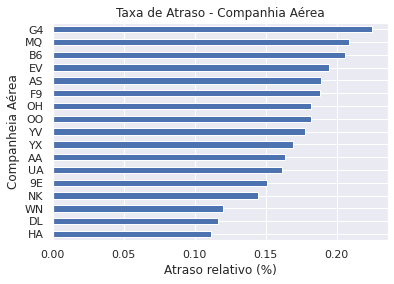

In [ ]:
"""
Plotando a taxa de atraso por companhia aérea para melhor visualização
"""
op_carrier = taxa_atraso(data, 'OP_CARRIER')
op_carrier = op_carrier.sort_values('Taxa de Atraso', ascending=True)

plt.xlabel("Atraso relativo (%)")
plt.ylabel("Companheia Aérea")
op_carrier['Taxa de Atraso'].plot(kind='barh', 
                                  title='Taxa de Atraso - Companhia Aérea');

**Comentários:** Podemos perceber com este gráfico que as companhiam constumam possuir uma taxa relativa de atraso semelhante. No entanto, os vale a pena verificar os extremos. As 3 companhias aéreas com que mais apresentam atrasos são: Allegiant Air LLC (G4), Envoy Air Inc. (MQ) e Jetblue Airways Corporation (B6). Por outro lado, as empresas que menos apresentam atrasos são: Southwest Airlines (WN), Delta Air Lines (DL) e a Hawaiian Airlines (HA).

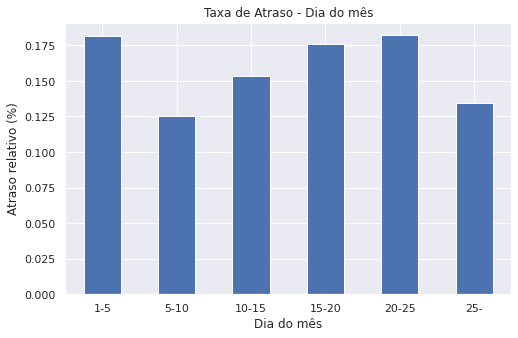

In [ ]:
"""
Plotando a taxa de atraso por dia do mês para melhor visualização
"""
data['DAY_OF_MONTH_CUT'] = pd.cut(data['DAY_OF_MONTH'], 
                                  bins=[1,5,10,15,20,25,31],
                                  labels=["1-5", "5-10", "10-15", "15-20", "20-25", "25-"]);

day_month = taxa_atraso(data, 'DAY_OF_MONTH_CUT')

fig, axes = plt.subplots(figsize=(8,5));

plt.xlabel("Dia do mês")
plt.ylabel("Atraso relativo (%)")
day_month['Taxa de Atraso'].plot(kind='bar', 
                                  title='Taxa de Atraso - Dia do mês', 
                                  rot=0);

**Comentários:** Podemos perceber que existe uma tendência maior a ocorrer atrasos nos 5 primeiros dias do mês e entre os dias 15 e 25 do mês.

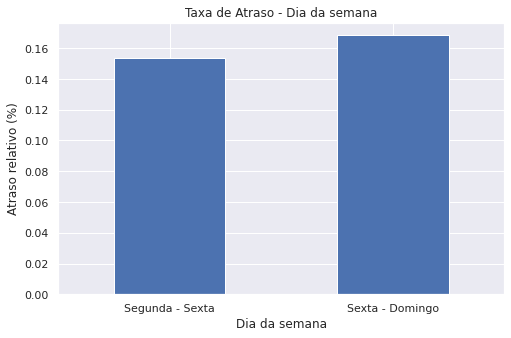

In [ ]:
"""
Plotando a taxa de atraso por dia da semana para melhor visualização
"""

data['DAY_OF_WEEK_CUT'] = pd.cut(data['DAY_OF_WEEK'], 
                                  bins=[1,5,7],
                                  labels=["Segunda - Sexta", "Sexta - Domingo"]);

day_week = taxa_atraso(data, 'DAY_OF_WEEK_CUT')

fig, axes = plt.subplots(figsize=(8,5));

plt.xlabel("Dia da semana")
plt.ylabel("Atraso relativo (%)")
day_week['Taxa de Atraso'].plot(kind='bar', 
                                  title='Taxa de Atraso - Dia da semana', 
                                  rot=0);

**Comentários:** É percebido que os fins de semana apresentam uma taxa de atraso ligeiramente maior, se comparado com os outros dias da semana

In [ ]:
"""
Analisando a taxa de atraso por aeroporto de origem
"""
origin = taxa_atraso(data, 'ORIGIN')
origin.sort_values('Taxa de Atraso', ascending=False)

,Total,Total Atraso,Taxa de Atraso
SHR,37,18,0.486486
OGD,17,7,0.411765
HGR,22,8,0.363636
PSM,53,19,0.358491
HTS,47,16,0.340426
...,...,...,...
ITO,1015,61,0.060099
PIR,58,3,0.051724
BTM,116,6,0.051724
LWS,128,4,0.031250


**Comentários:** Esta tabela nos mostram que os voos partindo dos aeroportos Sheridan County Airport (em Wyoming) e Ogden-Hinckley Airport (em Utah) possuem as maiores taxas de atrasos

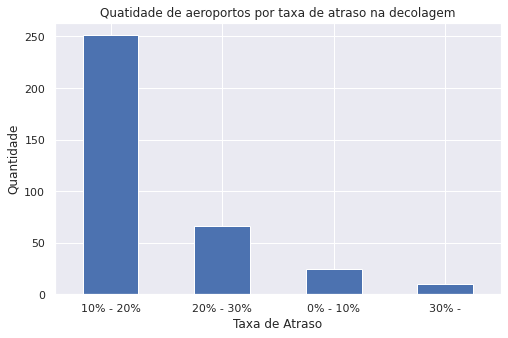

In [ ]:
origin['Taxa de Atraso CUT'] = pd.cut(origin['Taxa de Atraso'],
                                    bins=[0,0.1,0.2,0.3,0.486486],
                                    labels=["0% - 10%", "10% - 20%", "20% - 30%", "30% -"]);

fig, axes = plt.subplots(figsize=(8,5));

plt.xlabel("Taxa de Atraso")
plt.ylabel("Quantidade")
origin['Taxa de Atraso CUT'].value_counts().plot(kind='bar',
                                                 title='Quatidade de aeroportos por taxa de atraso na decolagem', 
                                                 rot=0);

**Comentários:** Com este gráfico percebemos que, para maioria dos aeroportos, entre 10 e 20% de seus voos apresentam atraso na decolagem

In [ ]:
"""
Analisando a taxa de atraso por aeroporto de destino
"""
dest = taxa_atraso(data, 'DEST')
dest.sort_values('Taxa de Atraso', ascending=False)

,Total,Total Atraso,Taxa de Atraso
OGD,17,6,0.352941
RIW,51,17,0.333333
AZA,949,298,0.314015
ASE,1845,576,0.312195
PPG,20,6,0.300000
...,...,...,...
CPR,173,9,0.052023
BTM,116,6,0.051724
TWF,178,9,0.050562
ATY,62,3,0.048387


**Comentários:** Esta tabela nos mostram que os voos com destino aos aeroportos Ogden-Hinckley Airport (em Utah) e Riverton Regional Airport (em Wyoming) possuem as maiores taxas de atrasos

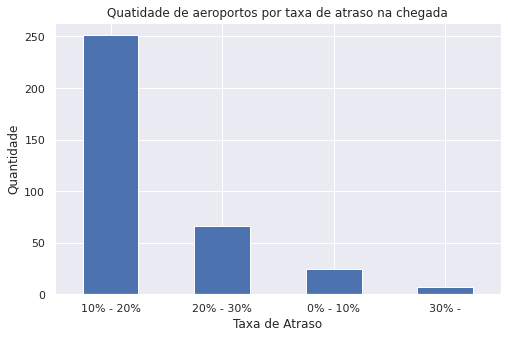

In [ ]:
dest['Taxa de Atraso CUT'] = pd.cut(origin['Taxa de Atraso'],
                                    bins=[0,0.1,0.2,0.3,0.352941],
                                    labels=["0% - 10%", "10% - 20%", "20% - 30%", "30% -"]);

fig, axes = plt.subplots(figsize=(8,5));

plt.xlabel("Taxa de Atraso")
plt.ylabel("Quantidade")
dest['Taxa de Atraso CUT'].value_counts().plot(kind='bar',
                                               title='Quatidade de aeroportos por taxa de atraso na chegada',
                                               rot=0);

**Comentários:** Quanto aos aeroportos de destino percebe-se um cenário semelhante, para maioria dos aeroportos, entre 10 e 20% de seus voos apresentam atraso na chegada

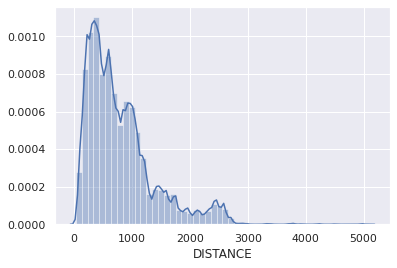

In [ ]:
"""
Analisando a distribuição da variável distância
"""
sns.distplot(data['DISTANCE']);

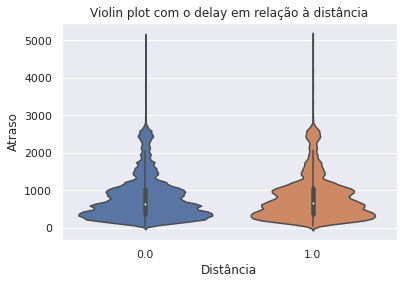

In [ ]:
"""
Utilizando violinplot para intuição
inicial da coluna distância
"""
plt.title("Violin plot com o delay em relação à distância")
ax = sns.violinplot(x="ARR_DEL15", y="DISTANCE", data=data);
ax.set(xlabel="Distância", ylabel="Atraso");

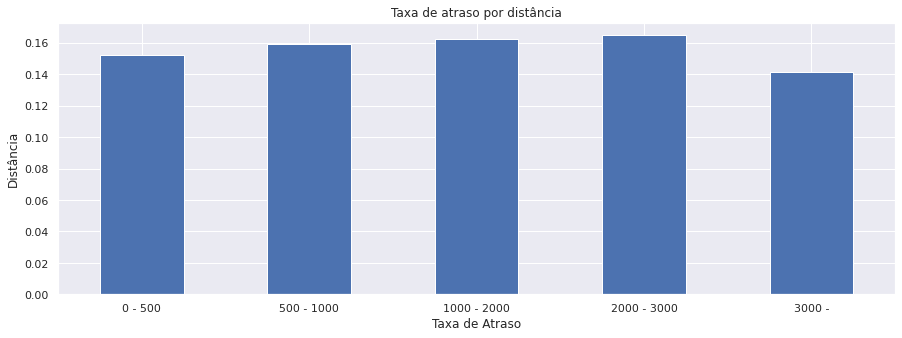

In [ ]:
data['DISTANCE CUT'] = pd.cut(data['DISTANCE'],
                              bins=[0,500,1000,2000,3000,5095],
                              labels=["0 - 500", 
                                      "500 - 1000", 
                                      "1000 - 2000", 
                                      "2000 - 3000",
                                      "3000 -"]);

distance = taxa_atraso(data, 'DISTANCE CUT')

fig, axes = plt.subplots(figsize=(15,5));

plt.xlabel("Taxa de Atraso")
plt.ylabel("Distância")
distance['Taxa de Atraso'].plot(kind='bar',
                                title='Taxa de atraso por distância',
                                rot=0);

**Comentários:** Podemos perceber que as distâncias dos voos costumam apresentar aproximadamente a mesma taxa de atraso

In [ ]:
"""
Excluindo variáveis temporárias de visualização
"""
data.drop(columns=['DAY_OF_MONTH_CUT', 'DAY_OF_WEEK_CUT', 'DISTANCE CUT'], inplace=True)

In [ ]:
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,DISTANCE
0,1,2,9E,N8688C,3280,GNV,ATL,601.0,0.0,0600-0659,722.0,0.0,300.0
1,1,2,9E,N348PQ,3281,MSP,CVG,1359.0,0.0,1400-1459,1633.0,0.0,596.0
2,1,2,9E,N8896A,3282,DTW,CVG,1215.0,0.0,1200-1259,1329.0,0.0,229.0
3,1,2,9E,N8886A,3283,TLH,ATL,1521.0,0.0,1500-1559,1625.0,0.0,223.0
4,1,2,9E,N8974C,3284,ATL,FSM,1847.0,0.0,1900-1959,1940.0,0.0,579.0


## **Modelagem Inicial**

Criação de um modelo básico inicial, com xgboost como classificador e o algoritmo target encoding para codificar as variáveis categóricas, que é um algoritmo que apresenta uma boa performance e, como estou utilizando um classificador baseado em árvore de decisão, não é sugerido utilizar o one-hot encoding por exemplo, já que aumentaria muito a dimensionalidade da base

In [ ]:
"""
Dropando registros com valores faltantes
"""
data.dropna(inplace=True)

In [ ]:
"""
Buscando colunas que são object para encoding
"""
categorical_columns = data.select_dtypes(include='object').columns
categorical_columns

Index(['OP_CARRIER', 'TAIL_NUM', 'ORIGIN', 'DEST', 'DEP_TIME_BLK'], dtype='object')

In [ ]:
"""
Criando pipeline inicial
"""
encoder = ce.TargetEncoder(cols=categorical_columns)

model = XGBClassifier()

pipeline = Pipeline([('encoder', encoder), ('clf', model)])

In [ ]:
"""
Obtendo o resultado inicial com uma validação cruzada
com 5 folds
"""
data = data.sample(frac=1)

X = data.drop(columns='ARR_DEL15')
y = data['ARR_DEL15']

results = cross_validate(pipeline, X, y, cv=5, scoring=['precision', 
                                                        'recall', 
                                                        'f1', 
                                                        'roc_auc'])

In [ ]:
"""
Printando resultados inicias
"""
results

{'fit_time': array([67.18862224, 66.90130591, 66.81810522, 66.01139164, 67.32620192]),
 'score_time': array([2.42766309, 2.35164976, 2.24946856, 2.32370543, 2.32255435]),
 'test_f1': array([0.75524609, 0.74800219, 0.69475265, 0.72519637, 0.77242602]),
 'test_precision': array([0.77225102, 0.76820596, 0.74132091, 0.77587989, 0.8177268 ]),
 'test_recall': array([0.73897392, 0.7288339 , 0.65368923, 0.68072851, 0.73188097]),
 'test_roc_auc': array([0.89125437, 0.87281071, 0.81260283, 0.83215208, 0.88156972])}

**Comentários:** Tendo em vista o desbalanceamento da base, optarei por focar nas métricas fscore a área sobre a curva roc.

## **Lidando com desbalanceamento**

Utilizarei a técnica de *random under sampling* para minimizar o desbalanceamento da base'

In [ ]:
"""
Reduzindo aleatoriamente o número de registros em
que não ocorreu atraso, para diminuir o desbalanceamento
da base
"""
delay_no = data.loc[data['ARR_DEL15'] == 0]
delay_yes = data.loc[data['ARR_DEL15'] == 1]

delay_no = delay_no.sample(frac=0.2)

sampled_data = pd.concat([delay_no, delay_yes])

sampled_data['ARR_DEL15'].value_counts()

0.0    195545
1.0    187507
Name: ARR_DEL15, dtype: int64

In [ ]:
"""
Buscando variáveis categóricas para codificação
"""
categorical_columns = sampled_data.select_dtypes(include='object').columns

In [ ]:
"""
Pipeline inicial
"""
encoder = ce.TargetEncoder(cols=categorical_columns)

model = XGBClassifier()

pipeline = Pipeline([('encoder', encoder), ('clf', model)])

In [ ]:
"""
Obtendo o resultado inicial com uma validação cruzada
com 5 folds
"""
sampled_data = sampled_data.sample(frac=1)

X = sampled_data.drop(columns=['ARR_DEL15'])
y = sampled_data['ARR_DEL15']

results = cross_validate(pipeline, X, y, cv=5, scoring=['precision', 
                                                        'recall', 
                                                        'f1', 
                                                        'roc_auc'])

In [ ]:
"""
Printando resultados com balanceamento
"""
print('precision: {0} ({1})'.format(np.mean(results['test_precision']), 
                                    np.std(results['test_precision'])))
print('recall: {0} ({1})'.format(np.mean(results['test_recall']), 
                                 np.std(results['test_recall'])))
print('f1: {0} ({1})'.format(np.mean(results['test_f1']), 
                             np.std(results['test_f1'])))
print('roc_auc: {0} ({1})'.format(np.mean(results['test_roc_auc']), 
                                  np.std(results['test_roc_auc'])))

precision: 0.942909593963012 (0.000692804375975613)
recall: 0.7505426561778451 (0.0011285278700501878)
f1: 0.8357996010951568 (0.0007351983008504489)
roc_auc: 0.9064715775120671 (0.000661615146578626)


**Comentários:** Podemos perceber que o balanceamento melhorou consideravelmente o resultado

## **Interpretação do modelo**

Utilizando o método shap para avaliar a importância das características no modelo

In [ ]:
"""
Realizando encoding para analisar todas as variáveis
"""
X_encoded = encoder.fit_transform(X, y)
model.fit(X_encoded, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
"""
Criando Explainer para interpretação do modelo
"""
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_encoded)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
"""
Buscando um voo aleatório para intepretação
"""
index = X.sample(n=1).index.values[0]
index

5274

In [ ]:
"""
Visualizando o indivíduo escolhido
"""
shap.initjs()

shap.force_plot(explainer.expected_value, 
                shap_values[index,:], 
                X_encoded.iloc[index,:])

**Comentários:** Neste exemplo, em que houve atraso, é percebido que a característica mais importante foi o fato do voo ter atrasado para partir da origem 

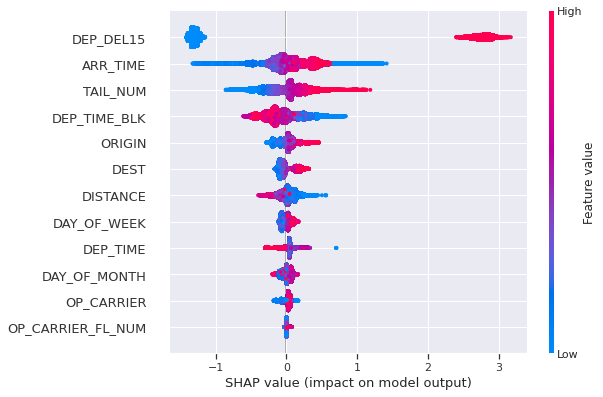

In [ ]:
"""
Plotando o impacto por características
"""
shap.summary_plot(shap_values, X_encoded)

**Comentários:** Analisando os valores shap, percebe-se que a característica de atraso na partida possui uma relação direta com o atraso na chegado (como poderíamos esperar), assim como o horário de chegada. Por outro lado, percebemos que as características de companhia aérea e número do voo não apresentam um impacto relevante para o modelo

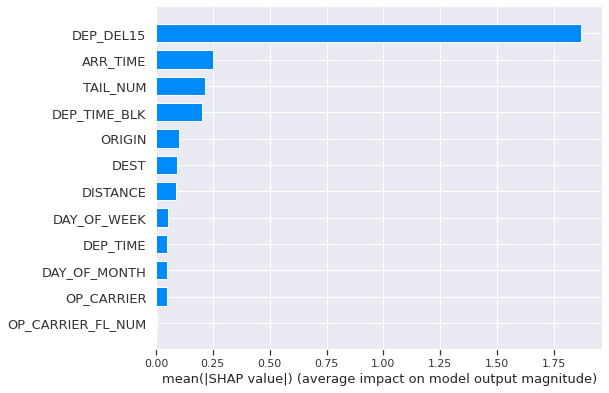

In [ ]:
"""
Visualizando impacto por características em termos absolutos
"""
shap.summary_plot(shap_values, X_encoded, plot_type="bar")

**Comentários:** Analisando a importância geral, vemos que o horário de partida é de longe a variável mais importante. Além disso, o número do voo, se o voo foi desviado ou cancelado apresentaram pouca ou nenhuma influência no modelo

## **Engenharia de características**

Criando algumas variáveis para tentar melhorar a performance do modelo

In [ ]:
"""
Aplicando uma transformação logarítmica na variável
distância, para suavizar tua assimetria
"""
sampled_data['DISTANCE_LOG'] = sampled_data['DISTANCE'].transform(np.log)

In [ ]:
"""
Separando a característica de bloco de tempo de partida
"""
sampled_data['DEP_TIME_BLK_INITIAL'] = sampled_data['DEP_TIME_BLK'].apply(lambda x: x.split('-')[0]).astype('float')
sampled_data['DEP_TIME_BLK_FINAL'] = sampled_data['DEP_TIME_BLK'].apply(lambda x: x.split('-')[1]).astype('float')

In [ ]:
"""
Característica com a diferença entre o horário entre o
horário real de partida e o horário mais otimista de
partida
"""
sampled_data['DIFF_DEP_INITIAL_ACTUAL'] = sampled_data['DEP_TIME'] - sampled_data['DEP_TIME_BLK_INITIAL']

In [ ]:
"""
Característica com a diferença entre o horário entre o
horário mais pessimista e o horário real de partida
"""
sampled_data['DIFF_DEP_FINAL_ACTUAL'] = sampled_data['DEP_TIME_BLK_FINAL'] - sampled_data['DEP_TIME']

In [ ]:
"""
Embaralhando a base e separando a label
"""
sampled_data = sampled_data.sample(frac=1)

X = sampled_data.drop(columns=['ARR_DEL15', 'DISTANCE', 'DEP_TIME_BLK'])
y = sampled_data['ARR_DEL15']

In [ ]:
"""
Buscando colunas que são object para encoding
"""
categorical_columns = X.select_dtypes(include='object').columns
categorical_columns

Index(['OP_CARRIER', 'TAIL_NUM', 'ORIGIN', 'DEST'], dtype='object')

In [ ]:
"""
Pipeline inicial
"""
encoder = ce.TargetEncoder(cols=categorical_columns)

model = XGBClassifier()

pipeline = Pipeline([('encoder', encoder), ('clf', model)])

In [ ]:
"""
Obtendo o resultado inicial com uma validação cruzada
com 5 folds
"""
results = cross_validate(pipeline, X, y, cv=5, scoring=['precision', 
                                                        'recall', 
                                                        'f1', 
                                                        'roc_auc'])

In [ ]:
"""
Printando resultados
"""
print('precision: {0} ({1})'.format(np.mean(results['test_precision']), 
                                    np.std(results['test_precision'])))
print('recall: {0} ({1})'.format(np.mean(results['test_recall']), 
                                 np.std(results['test_recall'])))
print('f1: {0} ({1})'.format(np.mean(results['test_f1']), 
                             np.std(results['test_f1'])))
print('roc_auc: {0} ({1})'.format(np.mean(results['test_roc_auc']), 
                                  np.std(results['test_roc_auc'])))

precision: 0.9385250353119708 (0.0013619740896722865)
recall: 0.7558704216645844 (0.0030419412859071363)
f1: 0.8373487502431354 (0.0019098894396492674)
roc_auc: 0.9079632017337476 (0.0015127388269435358)


## **Interpretando o resultado**

In [ ]:
"""
Dividindo base entre treino e teste, para obter as probabilidades
e analisar visualmente o resultado
"""
sampled_data = sampled_data.sample(frac=1)

X = sampled_data.drop(columns=['ARR_DEL15', 'DISTANCE', 'DEP_TIME_BLK'])
y = sampled_data['ARR_DEL15']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)

In [ ]:
"""
Perfomando o treinamento e predição
"""
pipeline.fit(X_train, y_train)

probas = pipeline.predict_proba(X_test)

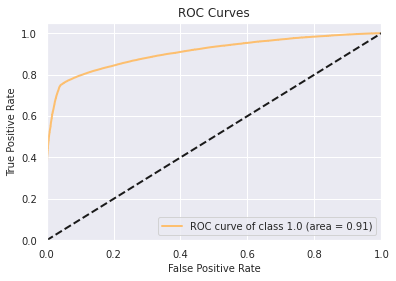

In [ ]:
"""
Plotando curva ROC
"""
skplt.metrics.plot_roc(y_test, probas, cmap='Paired', classes_to_plot=1, 
                       plot_micro=False, plot_macro=False);

**Comentários:** A curva roc mostra que o modelo consegue distinguir bem os clientes que compram dos que não compram o produto. Com um índice gini acima de 70%

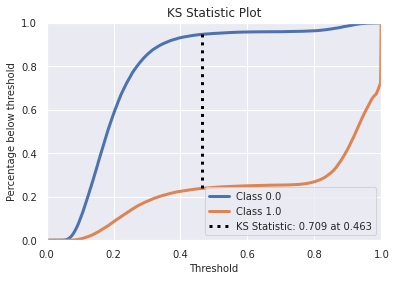

In [ ]:
"""
Plotando o gráfico para o teste de Kolmogorov-Smirnov
"""

skplt.metrics.plot_ks_statistic(y_test, probas);

**Comentários:** Com o teste de Kolmogorov-Smirnov podemos perceber que o ponto com maior distinção entre as taxas de verdadeiro positivo e de falso positivo no modelo, se dá com o limiar de 46.3% na probabilidade do classificador

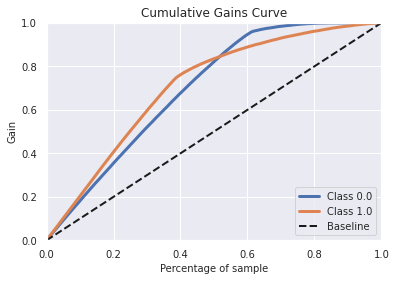

In [ ]:
"""
Plotando o gráfico de curva de ganho acumulativo
"""

skplt.metrics.plot_cumulative_gain(y_test, probas);

**Comentários:** O gráfico de ganho acumulativo nos mostra que atingindo os ~40% das observações, o modelo garantirá que 80% dos voos atrasados estejam nesse grupo, enquanto a seleção aleatória forneceria apenas 40% destes voos.

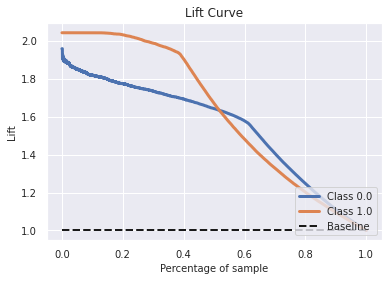

In [ ]:
"""
Plotando lift curve
"""
skplt.metrics.plot_lift_curve(y_test, probas);

**Comentários:** Complementar ao ganho acumulativo, a curva de eleveção nos mostra que se a incidência média de alvos for 40%, o aumento será ~2. Portanto, o modelo permite encontrar aproximadamente 2 vezes mais possíveis voos atrasados, em comparação com a escolha aleatória.


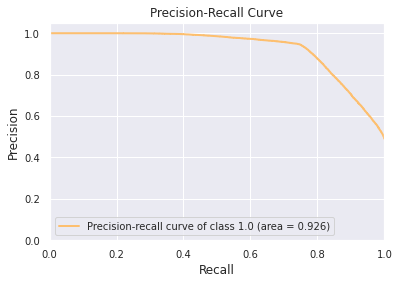

In [ ]:
"""
Plotando o gráfico precision x recall
"""
skplt.metrics.plot_precision_recall(y_test, probas, plot_micro=False, cmap='Paired', classes_to_plot=1);

**Comentários:** A curva precisão x sensibilidade nos mostra que um balanço ótimo entre essas duas métricas, tendo em vista que se trata de um problema com desbalanceamento acentuado
